In [2]:
!pip install torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from string import punctuation
from sklearn.metrics import accuracy_score
import torch
from torch import nn, optim
import torch.nn.functional as F

In [4]:
data = pd.read_csv("amazon_cells_labelled.txt", sep="\t", \
                   header=None)
reviews = data.iloc[:,0].str.lower()
sentiment = data.iloc[:,1].values

In [5]:
for i in punctuation:
    reviews = reviews.str.replace(i,"")

In [6]:
words = ' '.join(reviews)
words = words.split()
vocabulary = set(words)
indexer = {word: index for (index, word) \
           in enumerate(vocabulary)}

In [7]:
indexed_reviews = []
for review in reviews:
    indexed_reviews.append([indexer[word] \
                            for word in review.split()])

In [8]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, \
                 hidden_size, n_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_size, \
                            n_layers, batch_first=True)
        self.output = nn.Linear(hidden_size, 1)
    def forward(self, x):
        out = self.embedding(x)
        out, _ = self.lstm(out)
        out = out.contiguous().view(-1, self.hidden_size)
        out = self.output(out)
        out = out[-1,0]
        out = torch.sigmoid(out).unsqueeze(0)
        return out

In [31]:
model = LSTM(len(vocabulary), 64, 128, 3)
model

LSTM(
  (embedding): Embedding(1905, 64)
  (lstm): LSTM(64, 128, num_layers=3, batch_first=True)
  (output): Linear(in_features=128, out_features=1, bias=True)
)

In [32]:
loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 10

In [34]:
losses = []
acc = []
for e in range(1, epochs+1):
    single_loss = []
    preds = []
    targets = []
    for i, r in enumerate(indexed_reviews):
        if len(r) <= 1:
            continue
        x = torch.Tensor([r]).long()
        y = torch.Tensor([sentiment[i]])
        pred = model(x)
        loss = loss_function(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        final_pred = np.round(pred.detach().numpy())
        preds.append(final_pred)
        targets.append(y)
        single_loss.append(loss.item())
    losses.append(np.mean(single_loss))
    accuracy = accuracy_score(targets,preds)
    acc.append(accuracy)
    if e%1 == 0:
        print("Epoch: ", e, "... Loss function: ", losses[-1], \
              "... Accuracy: ", acc[-1])



Epoch:  1 ... Loss function:  0.6692496327574644 ... Accuracy:  0.6167002012072434
Epoch:  2 ... Loss function:  0.5767715798627203 ... Accuracy:  0.7072434607645876
Epoch:  3 ... Loss function:  0.4495677265883901 ... Accuracy:  0.806841046277666
Epoch:  4 ... Loss function:  0.3348444318670547 ... Accuracy:  0.8712273641851107
Epoch:  5 ... Loss function:  0.2418621740513809 ... Accuracy:  0.9124748490945674
Epoch:  6 ... Loss function:  0.1621171400724897 ... Accuracy:  0.9537223340040242
Epoch:  7 ... Loss function:  0.10258442657143327 ... Accuracy:  0.9748490945674044
Epoch:  8 ... Loss function:  0.08760947811813609 ... Accuracy:  0.9758551307847082
Epoch:  9 ... Loss function:  0.06587850529602372 ... Accuracy:  0.9828973843058351
Epoch:  10 ... Loss function:  0.049355582205271364 ... Accuracy:  0.9859154929577465


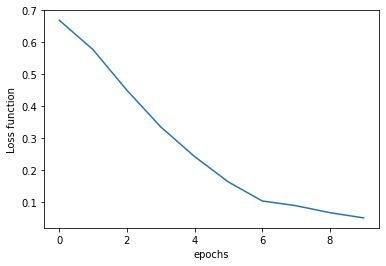

In [36]:
x_range = range(len(losses))
plt.plot(x_range, losses)
plt.xlabel("epochs")
plt.ylabel("Loss function")
plt.show()

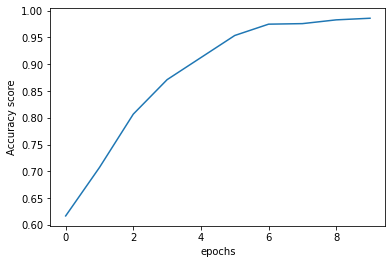

In [37]:
x_range = range(len(acc))
plt.plot(x_range, acc)
plt.xlabel("epochs")
plt.ylabel("Accuracy score")
plt.show()